# Particle Classification CNN (Image-Only): 4-Class Classification

This notebook trains a CNN to classify cloud particles into 4 phases using **ONLY particle images**.

This serves as a baseline to:
1. Test the quality of the image data and preprocessing
2. Establish baseline performance using morphological features alone
3. Compare against the hybrid model that includes environmental features

**Input:** 128x128 grayscale particle images  
**Output:** 4-class classification
- Phase 0: Liquid
- Phase 1: Solid (Ice)
- Phase 2: Donut
- Phase 3: Noise

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For faster image loading
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

print(f"TensorFlow version: {tf.__version__}")

## 2. Load and Prepare Data

**NOTE:** You need to have a DataFrame with the following columns:
- `particle_idx_seq`: matches the particle_X.png filenames
- `phase`: 0 for liquid, 1 for solid, 2 for donut, 3 for noise

In [3]:
#connect to google drive
from google.colab import drive
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

drive.mount('/content/drive')

Found GPU at: /device:GPU:0
Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/GEOG5100/aircraft_ml/'

## 3. Load Particle Images

In [5]:
def load_particle_image(particle_num, image_dir=base_path, target_size=(128, 128)):
    """
    Load a single particle image and preprocess it.

    Parameters:
    -----------
    particle_num : int
        Particle number (corresponds to particle_X.png)
    image_dir : str
        Directory containing particle images
    target_size : tuple
        Target image size (height, width)

    Returns:
    --------
    image : np.ndarray
        Normalized image array of shape (target_size[0], target_size[1], 1)
    """
    # Check all possible directories in order
    subdirs = ['liquid', 'solid', 'donut', 'noise']

    for subdir in subdirs:
        img_path = os.path.join(image_dir, f'particle_images_filtered/{subdir}', f'particle_{particle_num}.png')
        if os.path.exists(img_path):
            # Load image as grayscale
            img = Image.open(img_path).convert('L')

            # Resize if necessary
            img = img.resize(target_size)

            # Convert to numpy array and normalize to [0, 1]
            img_array = np.array(img, dtype=np.float32) / 255.0

            # Add channel dimension
            img_array = np.expand_dims(img_array, axis=-1)

            return img_array

    print(f"Warning: Image not found for particle {particle_num}")
    return None

In [6]:
# Load labeled data
df = pd.read_csv(base_path+'particle_images_filtered/particle_phases.csv')
if df is None:
    raise ValueError("Please load your labeled dataframe before proceeding")

In [7]:
# Load all images (FAST VERSION with parallel processing)
print("Loading particle images in parallel...")

def load_image_wrapper(args):
    """Wrapper function for parallel image loading"""
    idx, particle_num = args
    img = load_particle_image(particle_num)
    return idx, img

# Prepare arguments for parallel processing
load_args = [(idx, row['particle_idx_seq'])
             for idx, row in df.iterrows()]

# Load images in parallel using ThreadPoolExecutor
images = []
valid_indices = []

with ThreadPoolExecutor(max_workers=8) as executor:
    # Use tqdm for progress bar
    results = list(tqdm(executor.map(load_image_wrapper, load_args),
                        total=len(load_args),
                        desc="Loading images"))

    for idx, img in results:
        if img is not None:
            images.append(img)
            valid_indices.append(idx)

# Convert to numpy array
X_images = np.array(images)

# Filter dataframe to only include particles with valid images
df_valid = df.loc[valid_indices].reset_index(drop=True)

print(f"\nSuccessfully loaded {len(X_images)} images")
print(f"Image shape: {X_images.shape}")

Loading particle images in parallel...


Loading images:   3%|▎         | 209/7182 [00:30<10:43, 10.84it/s]

Loading images:   5%|▌         | 392/7182 [00:48<10:50, 10.43it/s]

Loading images:   7%|▋         | 484/7182 [00:57<14:06,  7.92it/s]

Loading images:   7%|▋         | 502/7182 [00:59<10:50, 10.27it/s]

Loading images:  10%|█         | 734/7182 [01:21<09:09, 11.74it/s]

Loading images:  12%|█▏        | 859/7182 [01:33<14:21,  7.34it/s]

Loading images:  16%|█▋        | 1169/7182 [02:02<08:54, 11.25it/s]

Loading images:  17%|█▋        | 1199/7182 [02:05<10:16,  9.71it/s]

Loading images:  22%|██▏       | 1556/7182 [02:39<08:06, 11.56it/s]

Loading images:  23%|██▎       | 1679/7182 [02:50<06:56, 13.21it/s]

Loading images:  27%|██▋       | 1920/7182 [03:13<07:50, 11.19it/s]

Loading images:  27%|██▋       | 1953/7182 [03:16<08:41, 10.03it/s]

Loading images:  35%|███▌      | 2547/7182 [04:13<07:03, 10.94it/s]

Loading images:  36%|███▌      | 2560/7182 [04:15<09:56,  7.75it/s]

Loading images:  37%|███▋      | 2646/7182 [04:23<06:15, 12.07it/s]

Loading images:  38%|███▊      | 2740/7182 [04:32<10:30,  7.05it/s]

Loading images:  40%|███▉      | 2862/7182 [04:44<06:38, 10.85it/s]

Loading images:  51%|█████▏    | 3682/7182 [06:01<06:19,  9.23it/s]

Loading images:  86%|████████▌ | 6157/7182 [09:45<01:26, 11.83it/s]

Loading images:  86%|████████▌ | 6187/7182 [09:48<01:27, 11.32it/s]

Loading images: 100%|█████████▉| 7156/7182 [11:21<00:02, 10.54it/s]

Loading images: 100%|█████████▉| 7158/7182 [11:21<00:02,  8.30it/s]

Loading images: 100%|█████████▉| 7175/7182 [11:22<00:00, 16.40it/s]

Loading images: 100%|██████████| 7182/7182 [11:23<00:00, 10.51it/s]


Successfully loaded 7153 images
Image shape: (7153, 128, 128, 1)


## 4. Prepare Labels

In [8]:
# Extract labels and convert to one-hot encoding
y = df_valid['phase'].values
y_categorical = to_categorical(y, num_classes=4)

print(f"Labels shape: {y_categorical.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Class 0 (Liquid): {np.sum(y == 0)} samples ({np.sum(y == 0) / len(y) * 100:.1f}%)")
print(f"Class 1 (Solid): {np.sum(y == 1)} samples ({np.sum(y == 1) / len(y) * 100:.1f}%)")
print(f"Class 2 (Donut): {np.sum(y == 2)} samples ({np.sum(y == 2) / len(y) * 100:.1f}%)")
print(f"Class 3 (Noise): {np.sum(y == 3)} samples ({np.sum(y == 3) / len(y) * 100:.1f}%)")

# Calculate class weights for imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"\nClass weights (to handle imbalance):")
for i, w in class_weight_dict.items():
    print(f"  Class {i}: {w:.2f}")

Labels shape: (7153, 4)
Class distribution: [2373 1997 2158  625]
Class 0 (Liquid): 2373 samples (33.2%)
Class 1 (Solid): 1997 samples (27.9%)
Class 2 (Donut): 2158 samples (30.2%)
Class 3 (Noise): 625 samples (8.7%)

Class weights (to handle imbalance):
  Class 0: 0.75
  Class 1: 0.90
  Class 2: 0.83
  Class 3: 2.86


## 5. Visualize Sample Particles

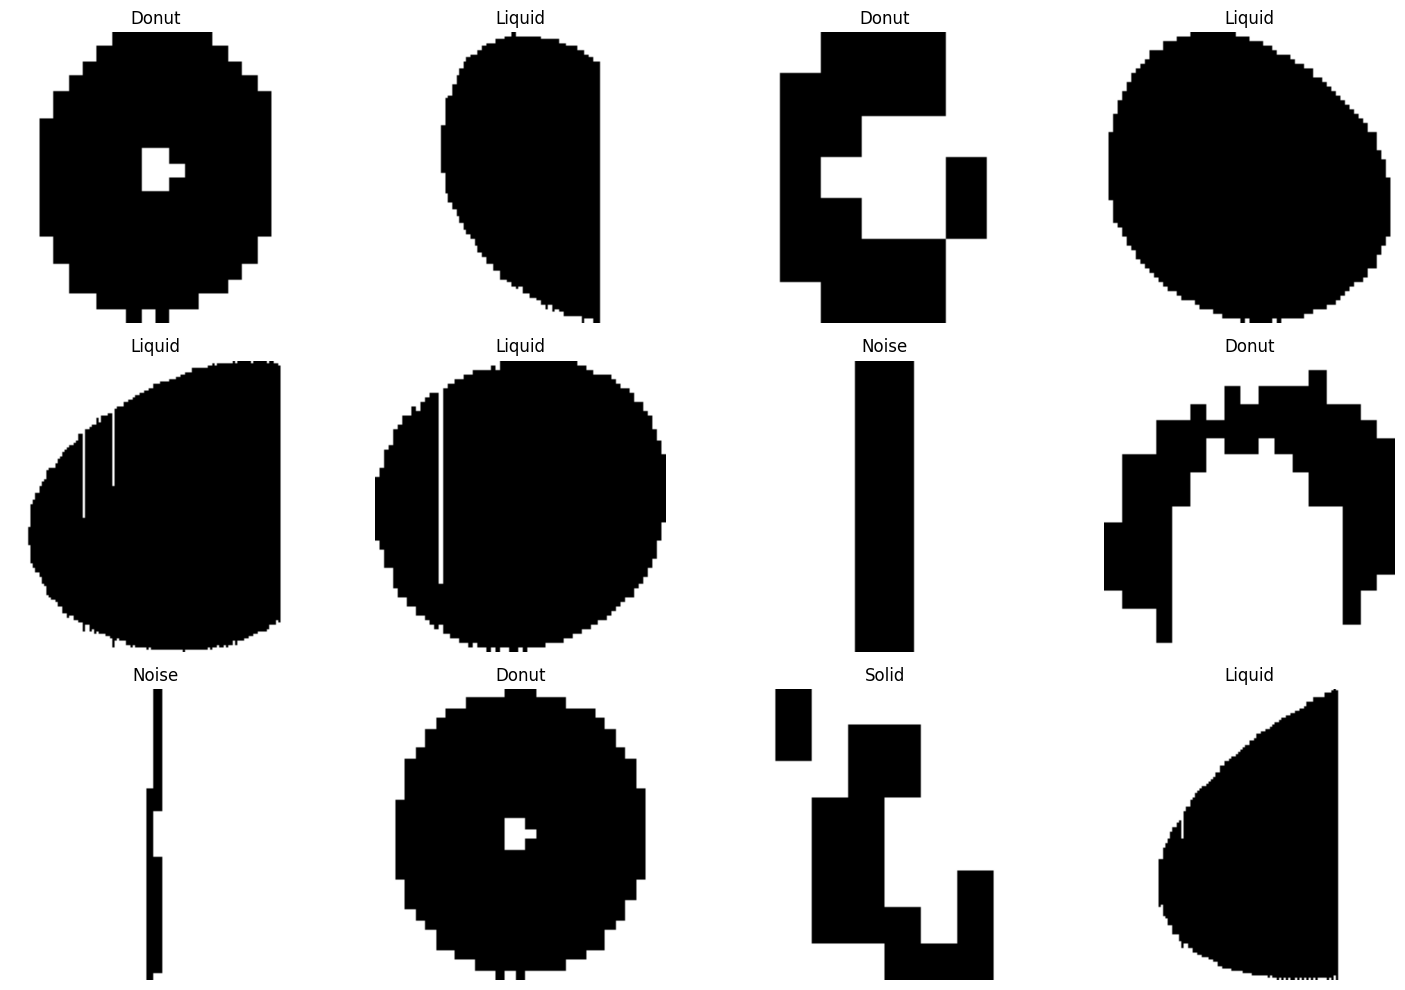

In [9]:
def get_class_name(label):
    """Convert numeric label to class name"""
    class_names = {0: 'Liquid', 1: 'Solid', 2: 'Donut', 3: 'Noise'}
    return class_names.get(label, 'Unknown')

# Display random samples from each class
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    idx = np.random.randint(0, len(X_images))
    plt.imshow(X_images[idx, :, :, 0], cmap='gray')
    plt.title(f'{get_class_name(y[idx])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 6. Train-Validation-Test Split

In [10]:
# First split: 90% temp, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_images, y_categorical,
    test_size=0.10,
    stratify=y_categorical,
    random_state=42
)

# Second split: 89% train, 11% validation (of temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.11,
    stratify=y_temp,
    random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTotal: {len(X_train) + len(X_val) + len(X_test)} samples")

Training set: 5728 samples
Validation set: 709 samples
Test set: 716 samples

Total: 7153 samples


## 6.5. Data Augmentation for Class Imbalance

Since we have class imbalance across 4 phases, we'll use data augmentation to:
1. Generate synthetic samples for minority classes during training
2. Improve model generalization
3. Balance the training batches

In [11]:
# Create ImageDataGenerator for data augmentation
# This will generate augmented images during training to help with class imbalance
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,      # Randomly shift images horizontally by 10%
    height_shift_range=0.1,     # Randomly shift images vertically by 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    vertical_flip=True,         # Randomly flip images vertically
    zoom_range=0.2,             # Randomly zoom in/out by 20%
    fill_mode='constant',       # Fill empty pixels with zeros (black background)
    cval=1                      # Value for filling empty pixels
)

# Fit the generator on training data
datagen.fit(X_train)

print("Data augmentation configured:")
print("  - Width/Height shift: ±10%")
print("  - Horizontal & vertical flip: Yes")
print("  - Zoom: ±20%")
print("\nThis will help balance the training by generating synthetic samples for minority classes during training.")

Data augmentation configured:
  - Width/Height shift: ±10%
  - Horizontal & vertical flip: Yes
  - Zoom: ±20%

This will help balance the training by generating synthetic samples for minority classes during training.


Visualizing data augmentation effects...


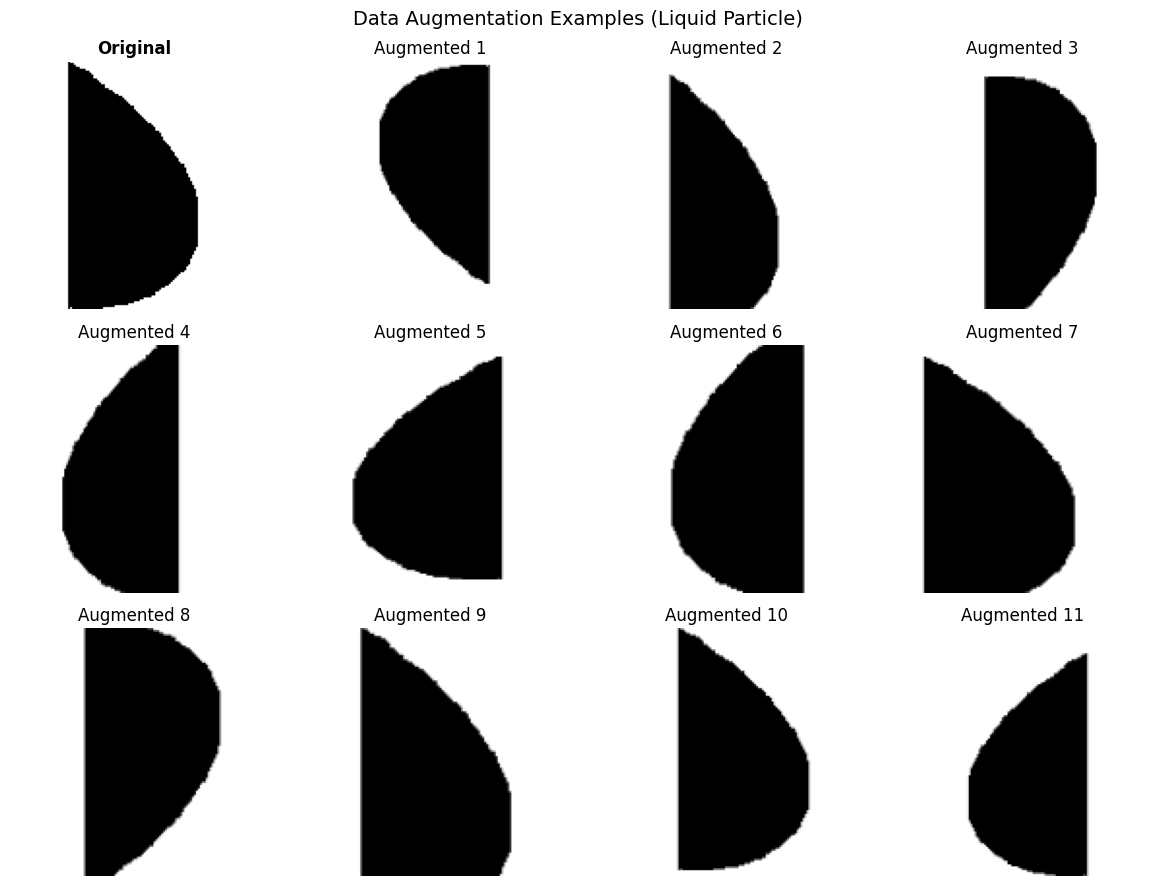

Data augmentation helps create synthetic training samples, especially useful for minority classes.


In [12]:
# Visualize augmented samples
# Show how data augmentation creates variations of the same particle
print("Visualizing data augmentation effects...")

# Pick a random particle from a minority class
sample_idx = np.random.randint(0, len(X_train))
sample_image = X_train[sample_idx:sample_idx+1]
sample_label = np.argmax(y_train[sample_idx])

# Generate augmented versions
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

# Show original
axes[0].imshow(sample_image[0, :, :, 0], cmap='gray')
axes[0].set_title('Original', fontweight='bold')
axes[0].axis('off')

# Generate and show 11 augmented versions
aug_iter = datagen.flow(sample_image, batch_size=1)
for i in range(1, 12):
    aug_image = next(aug_iter)
    axes[i].imshow(aug_image[0, :, :, 0], cmap='gray')
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle(f'Data Augmentation Examples ({get_class_name(sample_label)} Particle)', fontsize=14)
plt.tight_layout()
plt.show()

print("Data augmentation helps create synthetic training samples, especially useful for minority classes.")

## 7. Build the CNN Model (Image-Only)

This model uses a Sequential architecture with:
- 4 convolutional blocks (32 → 64 → 128 → 128 filters)
- BatchNormalization for stable training
- MaxPooling for dimensionality reduction
- Dropout for regularization
- Dense layers for 4-class classification (Liquid, Solid, Donut, Noise)

In [13]:
# Build Sequential CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    # Second convolutional block
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    # Third convolutional block
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    # Fourth convolutional block
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    # Flatten and fully connected layers
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Output layer (4-class classification: liquid, solid, donut, noise)
    Dense(4, activation='softmax')
], name='Particle_CNN_4Class')

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Particle_CNN_4Class"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,380,484 (9.08 MB)

 Trainable params: 2,379,780 (9.08 MB)

 Non-trainable params: 704 (2.75 KB)

## 8. Compile the Model

In [14]:
# Compile with appropriate loss function and optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


## 9. Set Up Callbacks

In [15]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    verbose=1,
    restore_best_weights=True
)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_particle_classifier_4class.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

print("Callbacks configured.")

Callbacks configured.


# Train the model with data augmentation and class weights
print("Starting training with data augmentation and class weights...")
print(f"Using class weights:")
for i, w in class_weight_dict.items():
    print(f"  Class {i} ({get_class_name(i)}): {w:.2f}")

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,  # Apply class weights to handle imbalance
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\nTraining complete!")

In [16]:
# Train the model
print("Starting training...")
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("\nTraining complete!")

Starting training...
Epoch 1/100
176/179 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5469 - loss: 1.2196
Epoch 1: val_accuracy improved from -inf to 0.08745, saving model to best_particle_classifier_4class.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.5489 - loss: 1.2137 - val_accuracy: 0.0874 - val_loss: 3.0062
Epoch 2/100
176/179 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7451 - loss: 0.6535
Epoch 2: val_accuracy improved from 0.08745 to 0.21157, saving model to best_particle_classifier_4class.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7452 - loss: 0.6534 - val_accuracy: 0.2116 - val_loss: 2.1026
Epoch 3/100
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7831 - loss: 0.5677
Epoch 3: val_accuracy improved from 0.21157 to 0.71368, saving model to best_particle_classifier_4class.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7832 - loss: 0.5676 - val_accuracy: 0.7137 - val_loss: 0.6630
Epoch 4/100
177/179 ━━━━━━━━━━━━━

## 11. Visualize Training History

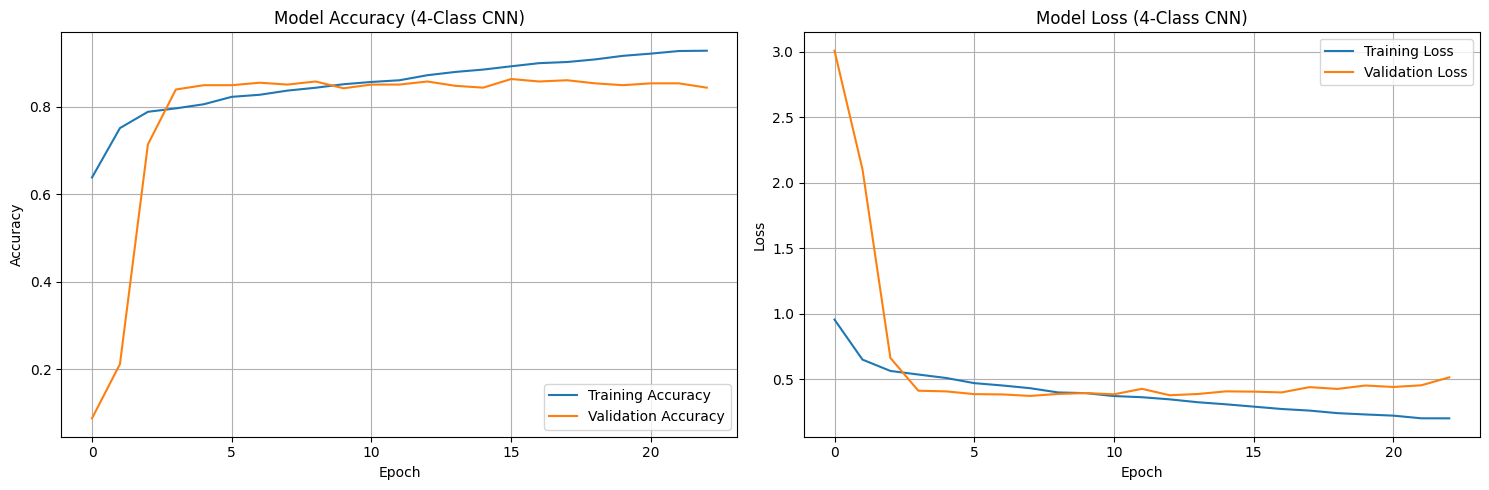


Final Training Accuracy: 0.9279
Final Validation Accuracy: 0.8434
Best Validation Accuracy: 0.8632


In [17]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy (4-Class CNN)')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss (4-Class CNN)')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

## 12. Evaluate on Test Set

In [18]:
# Load the best model
from keras.models import load_model

best_model = load_model('best_particle_classifier_4class.keras')

# Evaluate on training and test sets
_, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

print("=" * 50)
print("4-CLASS CNN (IMAGE-ONLY) PERFORMANCE")
print("=" * 50)
print(f'Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)')
print(f'Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)')
print(f'Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)')
print("=" * 50)

4-CLASS CNN (IMAGE-ONLY) PERFORMANCE
Training Accuracy:   0.9410 (94.10%)
Validation Accuracy: 0.8632 (86.32%)
Test Accuracy:       0.8128 (81.28%)


## 13. Generate Predictions and Metrics

In [19]:
# Make predictions on test set
y_pred_probs = best_model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f"Predictions shape: {y_pred_probs.shape}")
print(f"Predicted classes: {np.unique(y_pred)}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
Predictions shape: (716, 4)
Predicted classes: [0 1 2 3]


In [20]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Liquid', 'Solid', 'Donut', 'Noise']))

Test Accuracy: 0.8128

Classification Report:
              precision    recall  f1-score   support

      Liquid       0.88      0.84      0.86       237
       Solid       0.76      0.74      0.75       200
       Donut       0.79      0.83      0.81       216
       Noise       0.84      0.86      0.85        63

    accuracy                           0.81       716
   macro avg       0.82      0.82      0.82       716
weighted avg       0.81      0.81      0.81       716



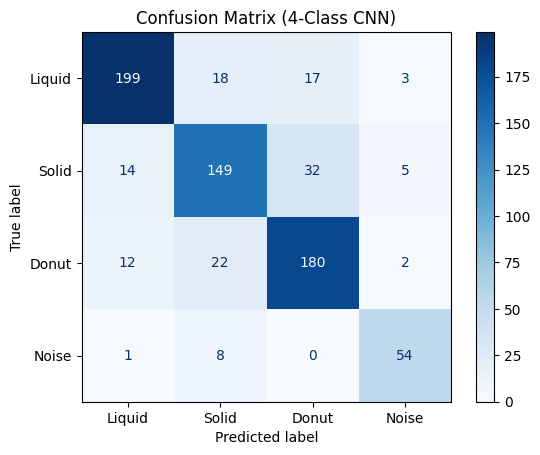


Confusion Matrix Analysis:
Liquid: 199/237 correct (84.0%)
Solid: 149/200 correct (74.5%)
Donut: 180/216 correct (83.3%)
Noise: 54/63 correct (85.7%)


In [21]:
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Liquid', 'Solid', 'Donut', 'Noise'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (4-Class CNN)')
plt.show()

print("\nConfusion Matrix Analysis:")
for i, label in enumerate(['Liquid', 'Solid', 'Donut', 'Noise']):
    correct = cm[i, i]
    total = cm[i, :].sum()
    print(f"{label}: {correct}/{total} correct ({correct/total*100:.1f}%)")

## 14. Visualize Predictions

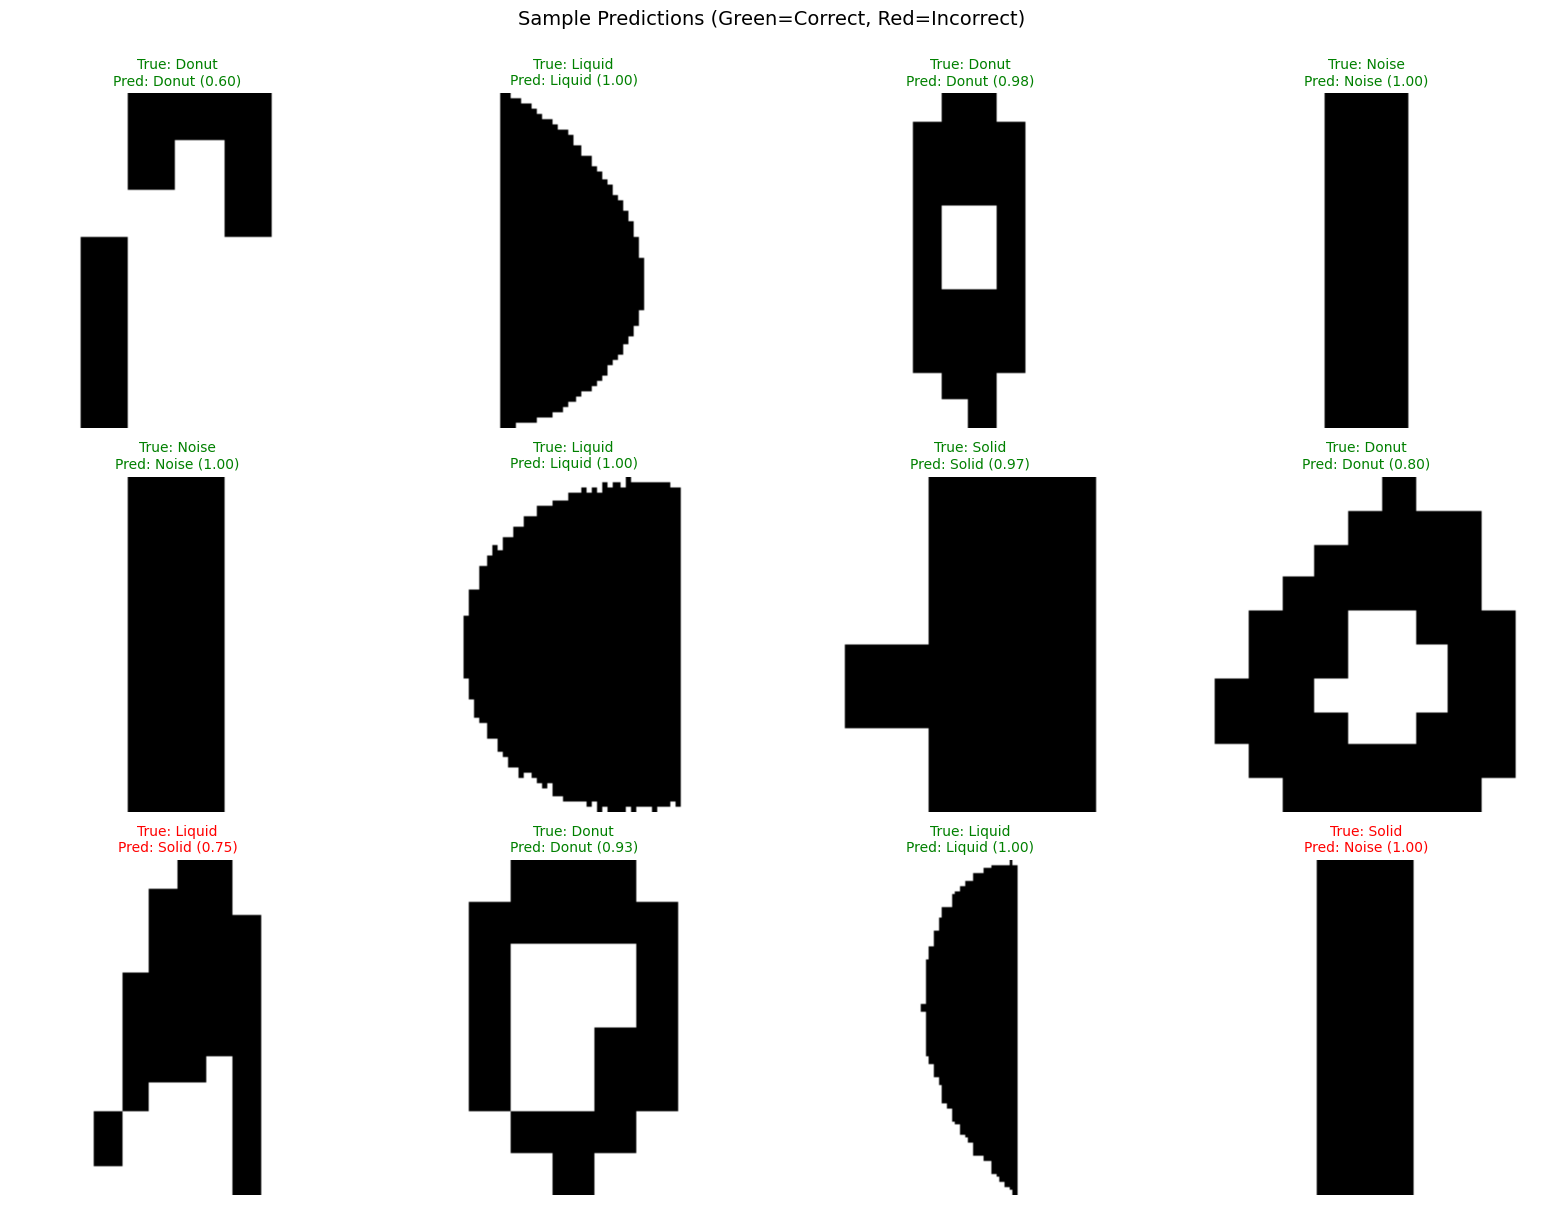

In [23]:
# Visualize some predictions
def plot_predictions(n_samples=12):
    """
    Plot sample predictions from the test set
    """
    plt.figure(figsize=(16, 12))

    for i in range(n_samples):
        idx = np.random.randint(0, len(X_test))

        # Get prediction
        pred_class = y_pred[idx]
        true_class = y_true[idx]
        confidence = y_pred_probs[idx][pred_class]

        # Determine if prediction is correct
        is_correct = pred_class == true_class
        color = 'green' if is_correct else 'red'

        plt.subplot(3, 4, i+1)
        plt.imshow(X_test[idx, :, :, 0], cmap='gray')
        plt.title(
            f'True: {get_class_name(true_class)}\n'
            f'Pred: {get_class_name(pred_class)} ({confidence:.2f})',
            color=color,
            fontsize=10
        )
        plt.axis('off')

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

plot_predictions()

## 15. Analyze Misclassifications

Total misclassifications: 134 out of 716 (18.72%)


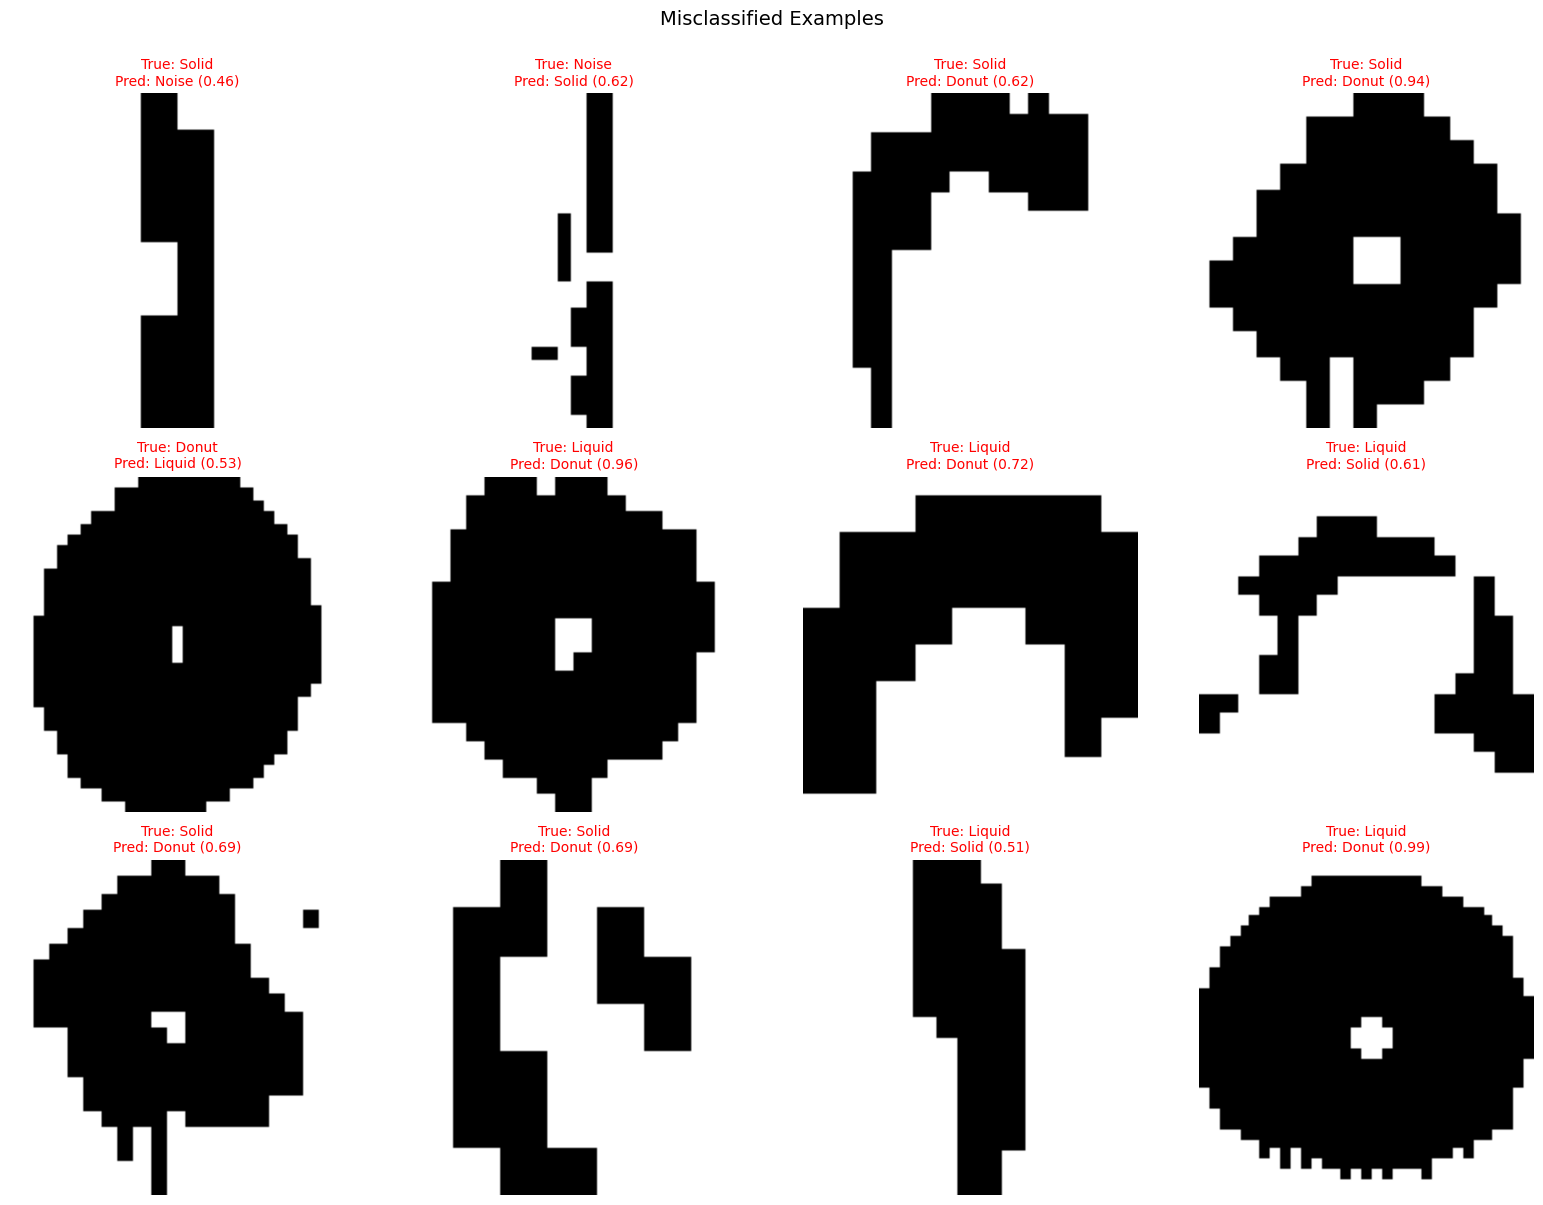

In [24]:
# Find misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total misclassifications: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

# Show some misclassified examples
if len(misclassified_indices) > 0:
    n_show = min(12, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, n_show, replace=False)

    plt.figure(figsize=(16, 12))
    for i, idx in enumerate(sample_indices):
        pred_class = y_pred[idx]
        true_class = y_true[idx]
        confidence = y_pred_probs[idx][pred_class]

        plt.subplot(3, 4, i+1)
        plt.imshow(X_test[idx, :, :, 0], cmap='gray')
        plt.title(
            f'True: {get_class_name(true_class)}\n'
            f'Pred: {get_class_name(pred_class)} ({confidence:.2f})',
            color='red',
            fontsize=10
        )
        plt.axis('off')

    plt.suptitle('Misclassified Examples', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found!")

## 16. Save Results Summary

In [25]:
# Create results summary
results_summary = {
    'model_type': 'CNN (4-Class Image-Only)',
    'total_samples': len(X_images),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'train_accuracy': train_acc,
    'val_accuracy': val_acc,
    'test_accuracy': test_acc,
    'best_epoch': np.argmax(history.history['val_accuracy']) + 1,
    'total_epochs': len(history.history['loss']),
    'misclassifications': len(misclassified_indices)
}

print("\n" + "=" * 60)
print("4-CLASS CNN - RESULTS SUMMARY")
print("=" * 60)
for key, value in results_summary.items():
    if 'accuracy' in key:
        print(f"{key:20s}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"{key:20s}: {value}")
print("=" * 60)

# Save to file (optional)
# import json
# with open('results_4class_image_only.json', 'w') as f:
#     json.dump(results_summary, f, indent=4)
# print("\nResults saved to 'results_4class_image_only.json'")


4-CLASS CNN - RESULTS SUMMARY
model_type          : CNN (4-Class Image-Only)
total_samples       : 7153
train_samples       : 5728
val_samples         : 709
test_samples        : 716
train_accuracy      : 0.9410 (94.10%)
val_accuracy        : 0.8632 (86.32%)
test_accuracy       : 0.8128 (81.28%)
best_epoch          : 16
total_epochs        : 23
misclassifications  : 134


## Notes and Next Steps

### This 4-Class Classification Model:
- Classifies particles into **4 phases**: Liquid (0), Solid (1), Donut (2), Noise (3)
- Uses **ONLY particle images** as input (128×128 grayscale)
- 4 convolutional blocks extract morphological features
- Sequential architecture (simpler than multi-input)
- Establishes baseline performance for image-only classification

### Model Architecture:
- Conv2D blocks: 32 → 64 → 128 → 128 filters
- BatchNormalization for stable training
- MaxPooling (2×2) for dimensionality reduction
- Dense layers: 256 → 128 → 64 neurons
- Dropout (0.2-0.3) for regularization
- Softmax output with 4 classes

### Phase Descriptions:
- **Liquid (0)**: Liquid water droplets
- **Solid (1)**: Ice crystals
- **Donut (2)**: Donut-shaped artifacts or special particle types
- **Noise (3)**: Noisy or invalid particle images

### Comparison with Hybrid Model:
Once you train the hybrid model (with environmental features), compare:
1. **Test accuracy improvement**: How much do environmental features help?
2. **Per-class performance**: Which phases benefit most from environmental data?
3. **Confidence scores**: Does the hybrid model have higher confidence?
4. **Misclassification patterns**: Does the hybrid model fix specific error types?
5. **Training stability**: Which model converges faster/more reliably?

### Potential Improvements:
1. **Data augmentation**: Rotation, flipping, scaling (especially for minority classes)
2. **Class weights**: Address class imbalance in the loss function (already implemented)
3. **Different architectures**: Try ResNet, VGG, or EfficientNet as backbone
4. **Hyperparameter tuning**: Learning rate, batch size, dropout rates
5. **Ensemble methods**: Combine multiple models
6. **Focal loss**: Better handling of hard examples and class imbalance

### Key Questions to Answer:
- What morphological features distinguish each phase?
- Are there systematic misclassifications between specific phase pairs?
- How well does the model generalize to different atmospheric conditions?
- Which phases are most challenging to classify from images alone?